# Introduction

Let's play with a Generative Adversarial Network! I'm going to try to build a simple GAN from scratch for a simple task -- handwritten digits. I feel like this shouldn't be too hard since the task is not very complicated, but GANs are notoriously difficult, so let's see what happens!

This tutorial was a nice reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Data

In [0]:
batch_size=50
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        # transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True)

emnist_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', train=True, download=True, split='letters',
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True)

Some code for viewing images.

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=''):
    image = unloader(tensor.cpu().clone().squeeze(0))
    print(image.size)
    plt.imshow(image)
    plt.title(title)
    plt.show()

Let's take a look at one batch of our data.

(28, 28)


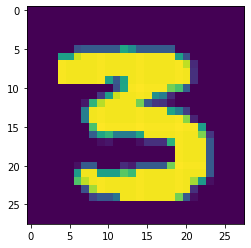

tensor(1.) tensor(0.)
tensor(5)
(28, 28)


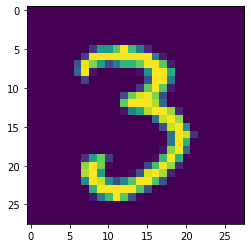

tensor(1.) tensor(0.)
tensor(9)
(28, 28)


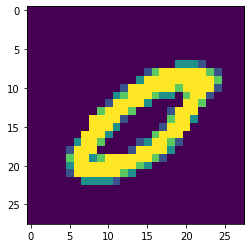

tensor(1.) tensor(0.)
tensor(8)
(28, 28)


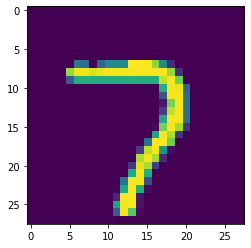

tensor(1.) tensor(0.)
tensor(9)
(28, 28)


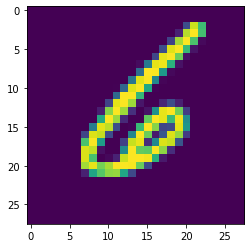

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


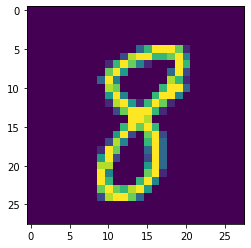

tensor(1.) tensor(0.)
tensor(0)
(28, 28)


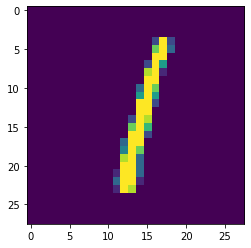

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


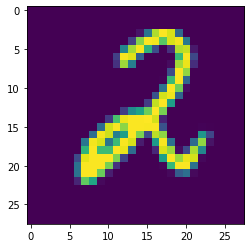

tensor(1.) tensor(0.)
tensor(9)
(28, 28)


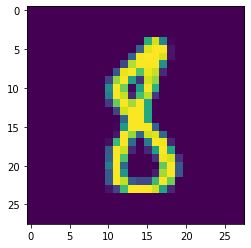

tensor(1.) tensor(0.)
tensor(4)
(28, 28)


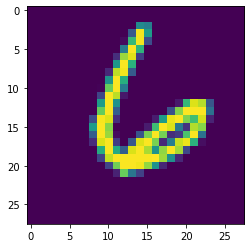

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


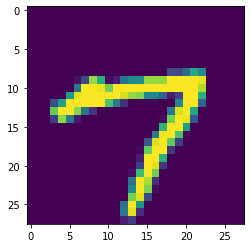

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


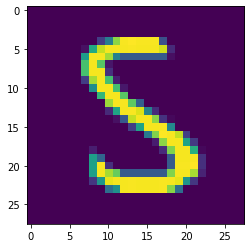

tensor(1.) tensor(0.)
tensor(0)
(28, 28)


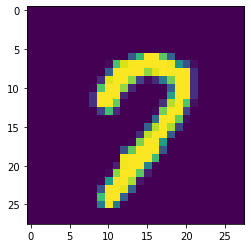

tensor(1.) tensor(0.)
tensor(5)
(28, 28)


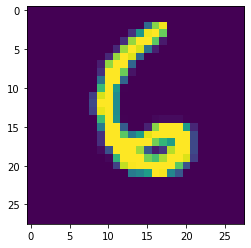

tensor(0.9961) tensor(0.)
tensor(8)
(28, 28)


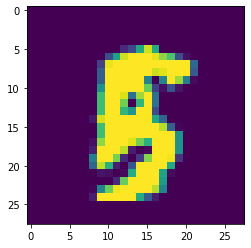

tensor(0.9961) tensor(0.)
tensor(4)
(28, 28)


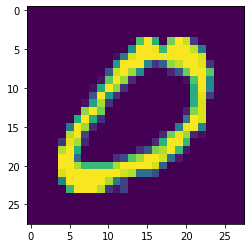

tensor(1.) tensor(0.)
tensor(8)
(28, 28)


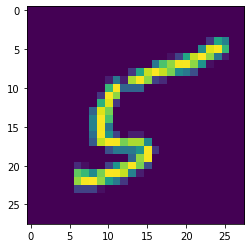

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


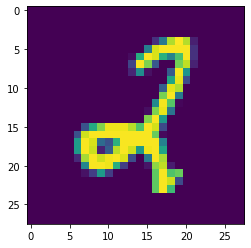

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


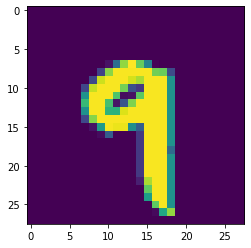

tensor(1.) tensor(0.)
tensor(3)
(28, 28)


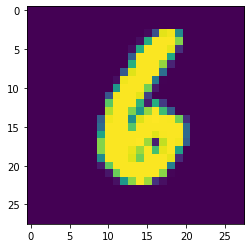

tensor(1.) tensor(0.)
tensor(5)
(28, 28)


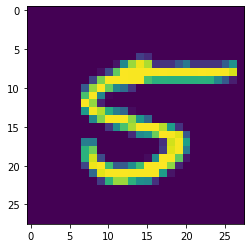

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


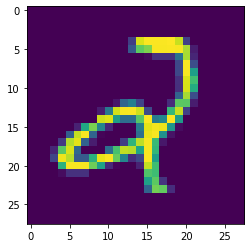

tensor(1.) tensor(0.)
tensor(5)
(28, 28)


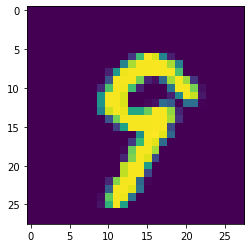

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


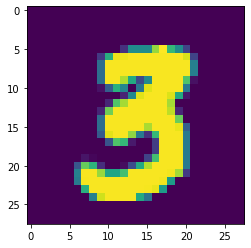

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


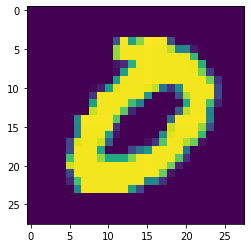

tensor(1.) tensor(0.)
tensor(0)
(28, 28)


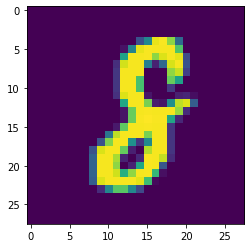

tensor(1.) tensor(0.)
tensor(2)
(28, 28)


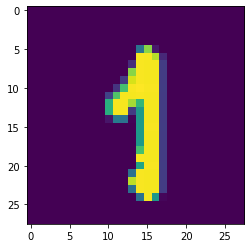

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


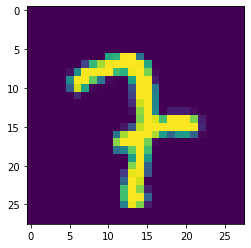

tensor(1.) tensor(0.)
tensor(8)
(28, 28)


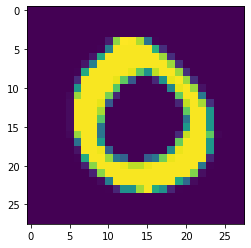

tensor(1.) tensor(0.)
tensor(3)
(28, 28)


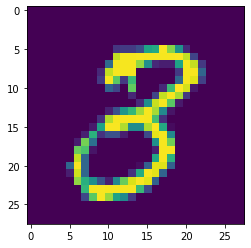

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


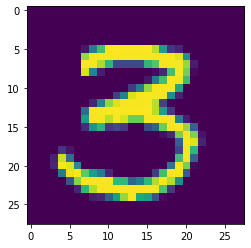

tensor(1.) tensor(0.)
tensor(3)
(28, 28)


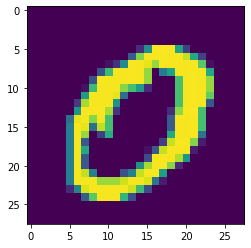

tensor(1.) tensor(0.)
tensor(4)
(28, 28)


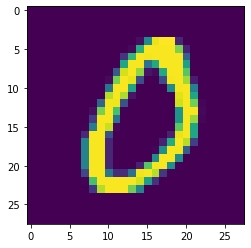

tensor(1.) tensor(0.)
tensor(0)
(28, 28)


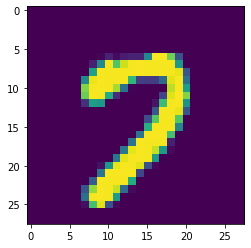

tensor(1.) tensor(0.)
tensor(2)
(28, 28)


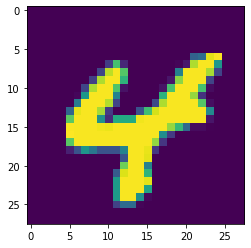

tensor(1.) tensor(0.)
tensor(1)
(28, 28)


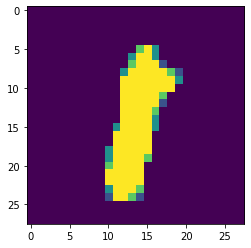

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


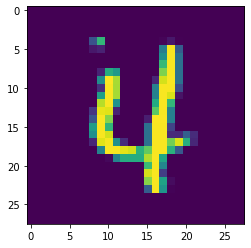

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


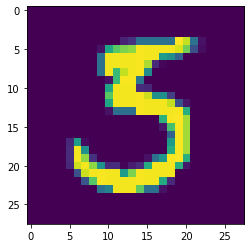

tensor(1.) tensor(0.)
tensor(4)
(28, 28)


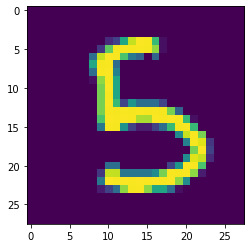

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


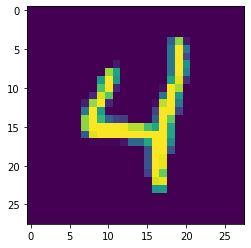

tensor(1.) tensor(0.)
tensor(6)
(28, 28)


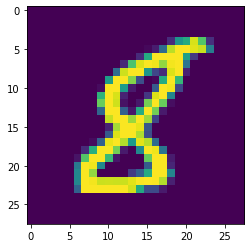

tensor(1.) tensor(0.)
tensor(1)
(28, 28)


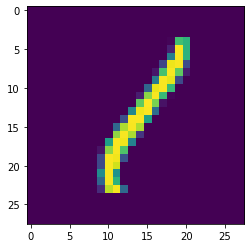

tensor(1.) tensor(0.)
tensor(2)
(28, 28)


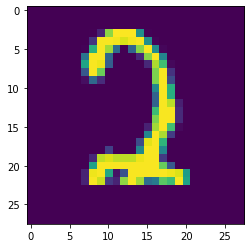

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


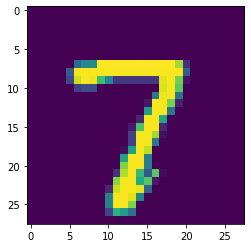

tensor(1.) tensor(0.)
tensor(9)
(28, 28)


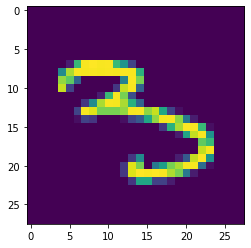

tensor(1.) tensor(0.)
tensor(4)
(28, 28)


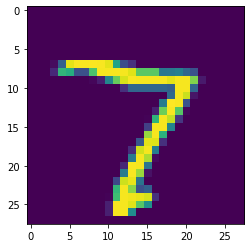

tensor(1.) tensor(0.)
tensor(7)
(28, 28)


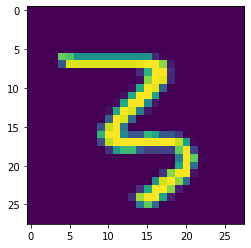

tensor(1.) tensor(0.)
tensor(0)
(28, 28)


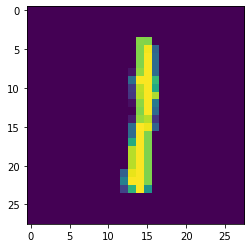

tensor(1.) tensor(0.)
tensor(3)
(28, 28)


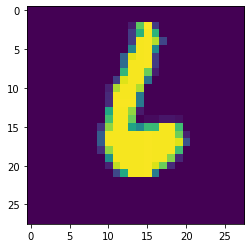

tensor(1.) tensor(0.)
tensor(8)
(28, 28)


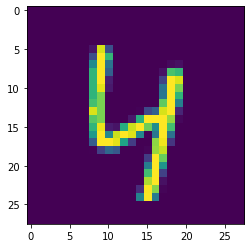

tensor(0.9961) tensor(0.)
tensor(0)


In [0]:
mnist_batch, labels = next(iter(kmnist_loader))
for i in range(input_batch.shape[0]):
    imshow(input_batch[i])
    print(torch.max(input_batch[i]), torch.min(input_batch[i]))
    print(labels[i])

Another quicker way to look at the data!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


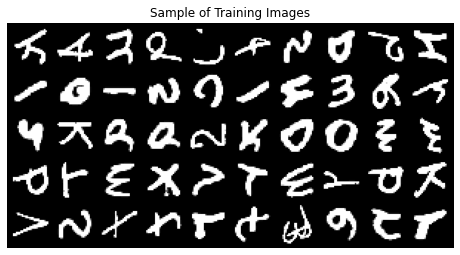

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


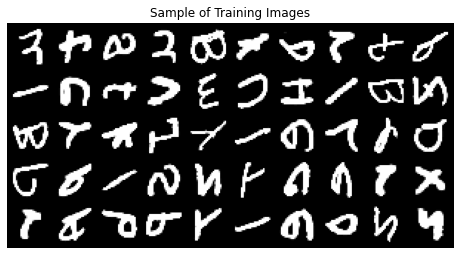

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


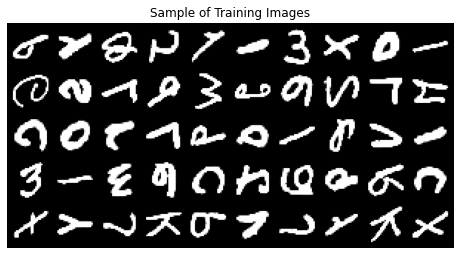

In [0]:
def view_batch(batch):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sample of Training Images")
    plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, nrow=10).cpu(),(1,2,0)))
    plt.show()

# view_batch(mnist_batch)
# ctr = 0
# for batch, labels in emnist_loader:
#   view_batch(batch)
#   ctr +=1
#   if ctr ==10:
#     break
  # view_batch(next(iter(emnist_loader)))
# batch, labels = next(iter(emnist_loader))

itr = iter(emnist_loader)
view_batch(next(itr)[0])
view_batch(next(itr)[0])
view_batch(next(itr)[0])

# view_batch(batch)

Looks like numbers to me!

# Architecture

We need a generator and a discriminator. The outputs of the generator and the inputs of the discriminator need to match the shape of our MNIST data. Most of this is from the tutorial. 

In [0]:
# number of channels in our images
nc = 1
# size of latent vector
nz = 100
# number of feature maps for generator (common factor)
ngf = 16
# number of feature maps for discriminator (common factor)
ndf = 16

Our generator uses a series of transposed convolutional layers, which allow us to increase the spatial dimension (height and width) of the tensor as it propogates through the generator. Here's some reading about transposed convolutional layers: https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11


Here is the key formula for the transposed convolution with kernel size $k$, padding of $p$, stride of $s$: if the square image has side length $i$ at first, it has side length $(i-1)*s + k - 2p$ after the tranposed convolution. Recall our images have a side length of 28.

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 9, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 22 x 22
            nn.ConvTranspose2d( ngf, nc, 9, 1, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

The rule to remember for shapes going in and out of normal convolutions is the following: for a conv with stride $s$, padding $p$, and kernel size $k$, if the square tensor has side length $i$ at first, it will have side length $(i+2p-k)/s +1$ after the conv. I'm pretty sure we can use all the same shapes as in our generator (in the opposite order of course).

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 9, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 22 x 22
            nn.Conv2d(ndf, ndf * 2, 9, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # final state size: 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some notes from the tutorial are that the batch norm layers and leaky relu activations help with gradient flow, leading to more stable training. What's curious to me is why we don't include any biases, and also why are final generated images have a final activation of tanh, when our data only ever has pixel intensities between 0 and 1. I might change this final activation to sigmoid to account for this. 

The tutorial also uses this neat custom weight initialization based on the DCGAN paper. Let's throw this in as well.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
gen_net = Generator().to(device)
disc_net= Discriminator().to(device)
gen_net.apply(weights_init)
disc_net.apply(weights_init)
print(gen_net)
print(disc_net)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 1, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)
Dis

## Losses and Optimizer

The discriminator and generator each have their own losses, and they are adversarially related. We train the discriminator with real samples and generated samples. When the discriminator correctly classifies real samples as real and generated samples as fake, its loss is low. When the generated creates samples that the discriminator deems real, the generator's loss is low. 

As you can see, both losses depend on the output of the discriminator. The discriminator's task is essentially binary classification (real or fake), so we use a binary cross entropy loss for both of our networks. The targets will be different though.

In [0]:
criterion = nn.BCELoss()
gen_optim = optim.Adam(gen_net.parameters(), lr=0.0002)
disc_optim = optim.Adam(disc_net.parameters(), lr=0.0002)
real_label = 1
fake_label = 0

# we'll have a fixed set of latent vectors so we can see our progress during training
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training

In [0]:
 def train_GAN(num_epochs=5, dataloader=train_loader):
    G_losses = []
    D_losses = []
    iters = 0
    img_list = []

    gen_net = Generator().to(device)
    disc_net= Discriminator().to(device)
    gen_net.apply(weights_init)
    disc_net.apply(weights_init)

    criterion = nn.BCELoss()
    gen_optim = optim.Adam(gen_net.parameters(), lr=0.0002)
    disc_optim = optim.Adam(disc_net.parameters(), lr=0.0002)
    real_label = 1
    fake_label = 0

    # we'll have a fixed set of latent vectors so we can see our progress during training
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            disc_net.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            # Forward pass real batch through D
            output = disc_net(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = gen_net(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = disc_net(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            disc_optim.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            gen_net.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = disc_net(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            gen_optim.step()

            # Output training stats
            if i % 500 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = gen_net(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
                plt.show()

            iters += 1
    return G_losses, D_losses, img_list

In [0]:
G_losses, D_losses, img_list = train_GAN()

Output hidden; open in https://colab.research.google.com to view.

Results

Most of this code is straight from the tutorial

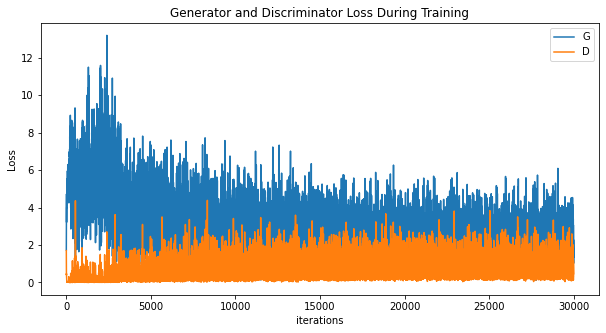

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.